# Week 5 submission

# Capston Project - Battle of Neighbourhoods.


## Introduction:

The aim of this project is to demostrate how Foursquare data can be used to explore or compare neighbourhoods or cities of choice and which problems can it solve.

## Problem description:

I have a friend, living in Bronx, New York, whose son has been accepted to the top school in the borough. Unfortunately the school is too far away from his neighbourhood, so he and his family need to move out closer to the school location. It is only natural, that he wants to move to a neighbourhood, which is very similar to his current home. He asked me to help find him neigbourhoods in the city, which are similar to his current neighbourhood.

## Target audience:

In the future, this approach could be used as a service, helping people moving homes to find neighbourhoods similar to the ones they have been living in and used to. It can partner up with real estate agencies or real estate marketplaces, like Zoopla, which have the same target audience, as the project and offer these services in order to enhance the benefits of using the company / service.

## Data description:

I will use the dataset from https://geo.nyu.edu/catalog/nyu_2451_34572 in order to get the list of 5 boroughs and all neighbourhoods in New York alongside with their respective latitude and longitude coordinates. Conveniently, they have also been downloaded onto the server by Coursera Instructor and can be found using the link https://cocl.us/new_york_dataset , which I will use for this project.

I will download the data, then filter it to get only neighbourhoods located in Bronx. Then I will use Foursquare API to explore areas around center of each neighbourhood and find 10 most common venues in each neighbourhood. Then k-means clustering algorithm will be used to group neighbourhoods into 4 groups. These groups will be used to find similar neighbourhoods in Bronx. Finally, I will use Folium library to visualize the neighbourhoods in Bronx and which clusters they belong to for convenience.

In [1]:
#import pandas for data analysis and numpy data handling
import pandas as pd
import numpy as np

#library for handling JSON files
import json

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data Downloaded!')

Data Downloaded!


Loading the data.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [5]:
neighbourhoods_data = newyork_data['features']

In [6]:
neighbourhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

The data we are looking for is in:
1. **'Coordinates'** key for latitude and longitude coordinates
2. **'Properties'** key and within that key: **'name'** of neighbourhood and **'borough'**.

Now we will tranform these nested Python dictionaries into a dataframe.

In [7]:
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude']
neighbourhoods = pd.DataFrame(columns = column_names)

In [8]:
neighbourhoods

Empty DataFrame
Columns: [Borough, Neighbourhood, Latitude, Longitude]
Index: []

In [9]:
for data in neighbourhoods_data:
    borough = data['properties']['borough']
    name= data['properties']['name']
    
    neighbourhood_latlon = data['geometry']['coordinates']
    neighbourhood_lat = neighbourhood_latlon[1]
    neighbourhood_lon = neighbourhood_latlon[0]
    
    neighbourhoods = neighbourhoods.append({'Borough': borough,
                                            'Neighbourhood': name,
                                            'Latitude': neighbourhood_lat,
                                            'Longitude': neighbourhood_lon}, ignore_index=True)

In [10]:
neighbourhoods.head()

Borough Neighbourhood   Latitude  Longitude
0   Bronx     Wakefield  40.894705 -73.847201
1   Bronx    Co-op City  40.874294 -73.829939
2   Bronx   Eastchester  40.887556 -73.827806
3   Bronx     Fieldston  40.895437 -73.905643
4   Bronx     Riverdale  40.890834 -73.912585

In [11]:
print('The Dataframe has {} boroughs and {} neighbourhoods'.format(
    len(neighbourhoods['Borough'].unique()),
    neighbourhoods.shape[0]))

The Dataframe has 5 boroughs and 306 neighbourhoods


Install Nominatim from geopy library to find latitude / longitude coordinates of Bronx.

In [12]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [13]:
address = "Bronx, New York City, NY"

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Bronx, New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bronx, New York City are 40.8506558, -73.8665241.


Install charting library Matplotlib and mapping library Folium for visualization.

In [14]:
import matplotlib.cm as cm
import matplotlib.colors as colors

!pip install folium==0.5.0

import folium

     |████████████████████████████████| 79 kB 2.5 MB/s eta 0:00:011
    Running setup.py install for folium ... done
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


Create a map of Bronx with neighbourhoods superimposed on top (at the moment they will also include other boroughs.

In [20]:
# create map of Bronx using latitude and longitude values
map_bronx = folium.Map(width=1200,height=600, location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighbourhood in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Borough'], neighbourhoods['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bronx)  
    
map_bronx

As we are only interested in Bronx, lets create a new dataframe with Bronx as the only borough.

In [21]:
bronx_data = neighbourhoods[neighbourhoods['Borough'] == 'Bronx'].reset_index(drop=True)
bronx_data.head()

Borough Neighbourhood   Latitude  Longitude
0   Bronx     Wakefield  40.894705 -73.847201
1   Bronx    Co-op City  40.874294 -73.829939
2   Bronx   Eastchester  40.887556 -73.827806
3   Bronx     Fieldston  40.895437 -73.905643
4   Bronx     Riverdale  40.890834 -73.912585

In [22]:
# create map of Bronx using latitude and longitude values
map_bronx = folium.Map(width=1200,height=600,location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighbourhood in zip(bronx_data['Latitude'], bronx_data['Longitude'], bronx_data['Borough'], bronx_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bronx)  
    
map_bronx

Now I will install required libraries to run API calls to Foursquare and explore Bronx further, as well as some other useful libraries.

In [23]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [24]:
CLIENT_ID = 'W40S05W1UCMBMYIKJLOPO41ZVGDUDAX2PH1XJACF3YRSKJVC' # your Foursquare ID
CLIENT_SECRET = 'MXTUAAC5F0X1HOQFVHLAT23HRYYAOI4X3MDTEQD0GCWK13HZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: W40S05W1UCMBMYIKJLOPO41ZVGDUDAX2PH1XJACF3YRSKJVC
CLIENT_SECRET:MXTUAAC5F0X1HOQFVHLAT23HRYYAOI4X3MDTEQD0GCWK13HZ


In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
LIMIT=100

bronx_venues = getNearbyVenues(names=bronx_data['Neighbourhood'],
                                   latitudes=bronx_data['Latitude'],
                                   longitudes=bronx_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Claremont Village
Concourse Village
Mount Eden
Mount Hope
Bronxdale
Allerton
Kingsbridge Heights


Check size of dataframe.

In [27]:
print(bronx_venues.shape)
bronx_venues.head()

(1211, 7)


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0     Wakefield               40.894705               -73.847201   
1     Wakefield               40.894705               -73.847201   
2     Wakefield               40.894705               -73.847201   
3     Wakefield               40.894705               -73.847201   
4     Wakefield               40.894705               -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1          Rite Aid       40.896649       -73.844846        Pharmacy  
2  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
3         Walgreens       40.896528       -73.844700        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

Check how many venues were returned for each neighborhood.

In [28]:
bronx_venues.rename(columns={'Neighborhood': 'Neighbourhood','Neighborhood Latitude': 'Neighbourhood Latitude','Neighborhood Longitude':'Neighbourhood Longitude'}, inplace=True)
bronx_venues.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0     Wakefield               40.894705               -73.847201   
1     Wakefield               40.894705               -73.847201   
2     Wakefield               40.894705               -73.847201   
3     Wakefield               40.894705               -73.847201   
4     Wakefield               40.894705               -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1          Rite Aid       40.896649       -73.844846        Pharmacy  
2  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
3         Walgreens       40.896528       -73.844700        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

In [29]:
bronx_venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  Neighbourhood Longitude  Venue  \
Neighbourhood                                                                 
Allerton                                 30                       30     30   
Baychester                               20                       20     20   
Bedford Park                             36                       36     36   
Belmont                                  97                       97     97   
Bronxdale                                14                       14     14   
Castle Hill                               8                        8      8   
City Island                              29                       29     29   
Claremont Village                        19                       19     19   
Clason Point                             10                       10     10   
Co-op City                               16                       16     16   
Concourse                                29                       29     29   
Concourse Village                        39                       39     39   
Country Club                              5                        5      5   
East Tremont                             16                       16     16   
Eastchester                              23                       23     23   
Edenwald                                  5                        5      5   
Edgewater Park                           19                       19     19   
Fieldston                                 3                        3      3   
Fordham                                  86                       86     86   
High  Bridge                             26                       26     26   
Hunts Point                              13                       13     13   
Kingsbridge                              70                       70     70   
Kingsbridge Heights                      33                       33     33   
Longwood                                  7                        7      7   
Melrose                                  26                       26     26   
Morris Heights                            7                        7      7   
Morris Park                              21                       21     21   
Morrisania                               22                       22     22   
Mott Haven                               21                       21     21   
Mount Eden                               28                       28     28   
Mount Hope                               15                       15     15   
North Riverdale                          21                       21     21   
Norwood                                  33                       33     33   
Olinville                                11                       11     11   
Parkchester                              35                       35     35   
Pelham Bay                               40                       40     40   
Pelham Gardens                           18                       18     18   
Pelham Parkway                           23                       23     23   
Port Morris                              10                       10     10   
Riverdale                                10                       10     10   
Schuylerville                            18                       18     18   
Soundview                                15                       15     15   
Spuyten Duyvil                           11                       11     11   
Throgs Neck                              10                       10     10   
Unionport                                21                       21     21   
University Heights                       24                       24     24   
Van Nest                                 23                       23     23   
Wakefield                                10                       10     10   
West Farms                               26                       26   

Create dummy variables.

In [30]:
# one hot encoding
bronx_onehot = pd.get_dummies(bronx_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bronx_onehot['Neighbourhood'] = bronx_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [bronx_onehot.columns[-1]] + list(bronx_onehot.columns[:-1])
bronx_onehot = bronx_onehot[fixed_columns]

bronx_onehot.head()

Neighbourhood  Accessories Store  African Restaurant  American Restaurant  \
0     Wakefield                  0                   0                    0   
1     Wakefield                  0                   0                    0   
2     Wakefield                  0                   0                    0   
3     Wakefield                  0                   0                    0   
4     Wakefield                  0                   0                    0   

   Arcade  Arepa Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0       0                 0            0           0                    0   
1       0                 0            0           0                    0   
2       0                 0            0           0                    0   
3       0                 0            0           0                    0   
4       0                 0            0           0                    0   

   Asian Restaurant  ...  Trail  Train Station  Video Game Store  Video Store  \
0                 0  ...      0              0                 0            0   
1                 0  ...      0              0                 0            0   
2                 0  ...      0              0                 0            0   
3                 0  ...      0              0                 0            0   
4                 0  ...      0              0                 0            0   

   Vietnamese Restaurant  Warehouse Store  Waste Facility  Wine Shop  \
0                      0                0               0          0   
1                      0                0               0          0   
2                      0                0               0          0   
3                      0                0               0          0   
4                      0                0               0          0   

   Wings Joint  Women's Store  
0            0              0  
1            0              0  
2            0              0  
3            0              0  
4            0              0  

[5 rows x 173 columns]

Examine size.

In [31]:
bronx_onehot.shape

(1211, 173)

In [32]:
Calculate the frequency of each venue.

SyntaxError: invalid syntax (<ipython-input-32-31dec1130832>, line 1)

In [33]:
bronx_grouped = bronx_onehot.groupby('Neighbourhood').mean().reset_index()
bronx_grouped

Neighbourhood  Accessories Store  African Restaurant  \
0              Allerton           0.000000            0.000000   
1            Baychester           0.000000            0.000000   
2          Bedford Park           0.000000            0.000000   
3               Belmont           0.000000            0.000000   
4             Bronxdale           0.000000            0.000000   
5           Castle Hill           0.000000            0.000000   
6           City Island           0.000000            0.000000   
7     Claremont Village           0.000000            0.000000   
8          Clason Point           0.000000            0.000000   
9            Co-op City           0.062500            0.000000   
10            Concourse           0.000000            0.000000   
11    Concourse Village           0.000000            0.000000   
12         Country Club           0.000000            0.000000   
13         East Tremont           0.000000            0.000000   
14          Eastchester           0.000000            0.000000   
15             Edenwald           0.000000            0.000000   
16       Edgewater Park           0.000000            0.000000   
17            Fieldston           0.000000            0.000000   
18              Fordham           0.011628            0.011628   
19         High  Bridge           0.000000            0.000000   
20          Hunts Point           0.000000            0.000000   
21          Kingsbridge           0.000000            0.000000   
22  Kingsbridge Heights           0.000000            0.000000   
23             Longwood           0.000000            0.000000   
24              Melrose           0.000000            0.000000   
25       Morris Heights           0.000000            0.000000   
26          Morris Park           0.000000            0.000000   
27           Morrisania           0.000000            0.000000   
28           Mott Haven           0.000000            0.000000   
29           Mount Eden           0.000000            0.000000   
30           Mount Hope           0.000000            0.000000   
31      North Riverdale           0.000000            0.000000   
32              Norwood           0.000000            0.000000   
33            Olinville           0.000000            0.000000   
34          Parkchester           0.000000            0.000000   
35           Pelham Bay           0.000000            0.000000   
36       Pelham Gardens           0.000000            0.000000   
37       Pelham Parkway           0.000000            0.000000   
38          Port Morris           0.000000            0.000000   
39            Riverdale           0.000000            0.000000   
40        Schuylerville           0.000000            0.000000   
41            Soundview           0.000000            0.000000   
42       Spuyten Duyvil           0.000000            0.000000   
43          Throgs Neck           0.000000            0.000000   
44            Unionport           0.000000            0.000000   
45   University Heights           0.000000            0.041667   
46             Van Nest           0.000000            0.000000   
47            Wakefield           0.000000            0.000000   
48           West Farms           0.000000            0.000000   
49   Westchester Square           0.000000            0.000000   
50       Williamsbridge           0.000000            0.000000   
51             Woodlawn           0.000000            0.000000   

    American Restaurant  Arcade  Arepa Restaurant  Art Gallery  Art Museum  \
0              0.000000    0.00          0.000000     0.000000    0.000000   
1              0.000000    0.05          0.000000     0.000000    0.000000   
2              0.000000    0.00          0.000000     0.000000    0.000000   
3              0.010309    0.00          0.000000     0.000000    0.000000   
4              0.000000    0.00          0.000000     0.000000    0.000000   
5              0.000000    0.00          0.

Create top 7 venues list.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = bronx_grouped['Neighbourhood']

for ind in np.arange(bronx_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bronx_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0      Allerton           Pizza Place           Supermarket   
1    Baychester            Donut Shop        Mattress Store   
2  Bedford Park                 Diner    Chinese Restaurant   
3       Belmont    Italian Restaurant           Pizza Place   
4     Bronxdale     Convenience Store                  Bank   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0         Deli / Bodega    Chinese Restaurant                   Spa   
1   Fried Chicken Joint           Pizza Place             Pet Store   
2           Pizza Place    Mexican Restaurant        Sandwich Place   
3         Deli / Bodega                Bakery          Dessert Shop   
4           Pizza Place           Coffee Shop    Chinese Restaurant   

   6th Most Common Venue          7th Most Common Venue  
0           Intersection            Fried Chicken Joint  
1         Discount Store                 Sandwich Place  
2            Supermarket             Spanish Restaurant  
3             Donut Shop                           Bank  
4  Performing Arts Venue  Paper / Office Supplies Store

Now the dataframe is ready, we define and apply K-means algorithm. First of all we will use elbow method to determine the optimal K.

In [36]:
bronx_grouped_clustering = bronx_grouped.drop('Neighbourhood', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(bronx_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

In [37]:
distortions

[3.788680857633006,
 3.440450847969646,
 3.166073515884707,
 2.942904405494065,
 2.7355987299270863,
 2.590765083376649,
 2.3506522398530594,
 2.36303997757079,
 2.1201513729034334]

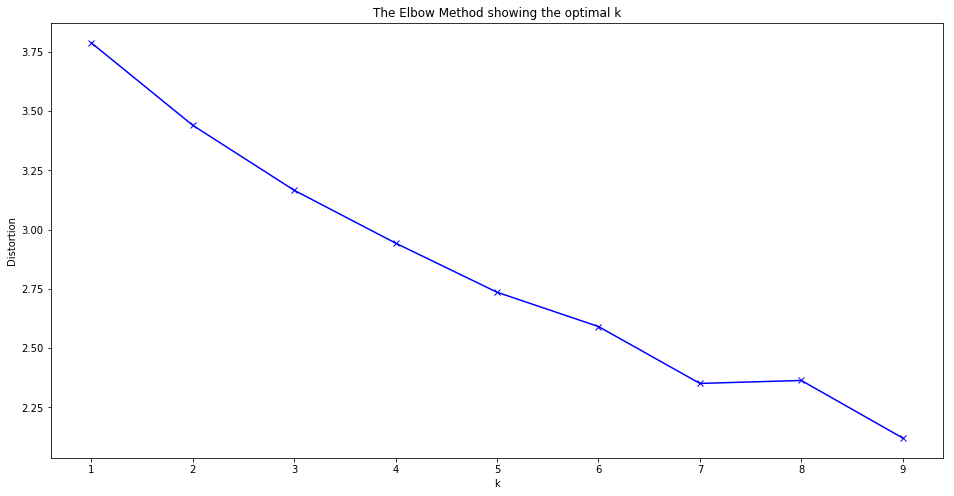

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From K Means elbow method we can conclude that an optimal number of clusters would be 7. Another candidate for an optimal k could be 9, but I believe that this would overcomplicate the model with 2 more clusters, while the reduction in error would be marginal.

Now we will run K-Means algorithm for k = 7.

In [38]:
# set number of clusters
kclusters = 7

bronx_grouped_clustering = bronx_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bronx_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 4, 4, 4, 6, 4, 2, 6, 6], dtype=int32)

Next step is to add the cluster labels to the venue data.

In [39]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bronx_merged = bronx_data

# merge york_grouped with york_data to add latitude/longitude for each neighborhood
bronx_merged = bronx_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

bronx_merged.head() # check the last columns!

ValueError: cannot insert Cluster Labels, already exists

In [40]:
bronx_merged['Cluster Labels'].unique

<bound method Series.unique of 0     0
1     6
2     4
3     5
4     6
5     4
6     2
7     0
8     1
9     4
10    4
11    4
12    4
13    0
14    2
15    4
16    0
17    6
18    6
19    0
20    0
21    0
22    2
23    4
24    2
25    2
26    6
27    4
28    3
29    4
30    4
31    0
32    0
33    4
34    6
35    4
36    4
37    4
38    4
39    6
40    0
41    2
42    2
43    4
44    2
45    2
46    4
47    2
48    2
49    4
50    0
51    4
Name: Cluster Labels, dtype: int32>

In [41]:
bronx_merged.shape

(52, 12)

## Visualizing the clusters on the map of Bronx

In [43]:
map_latitude = bronx_merged['Latitude'].mean()
map_longitude = bronx_merged['Longitude'].mean()

In [44]:
# create map
map_clusters = folium.Map(width=1200,height=600, location=[map_latitude, map_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bronx_merged['Latitude'], bronx_merged['Longitude'], bronx_merged['Neighbourhood'], bronx_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now we have a visual representation of clusters, which my friend can choose to pick a neighbourhood near his son's new school, which would be the most similar to the one they currently live in.

In [56]:
bronx_merged[bronx_merged['Cluster Labels']==0].head()

Borough       Neighbourhood   Latitude  Longitude  Cluster Labels  \
6    Bronx            Woodlawn  40.898273 -73.867315               0   
7    Bronx             Norwood  40.877224 -73.879391               0   
10   Bronx      Pelham Parkway  40.857413 -73.854756               0   
13   Bronx  University Heights  40.855727 -73.910416               0   
14   Bronx      Morris Heights  40.847898 -73.919672               0   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
6                    Pub         Deli / Bodega                   Bar   
7            Pizza Place                  Bank                  Park   
10           Bus Station    Frozen Yogurt Shop           Pizza Place   
13           Pizza Place                Bakery    Chinese Restaurant   
14    Spanish Restaurant                  Bank     Recreation Center   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
6            Pizza Place            Playground     Food & Drink Shop   
7     Chinese Restaurant              Pharmacy         Deli / Bodega   
10    Italian Restaurant          Liquor Store            Donut Shop   
13         Deli / Bodega  Fast Food Restaurant            Shoe Store   
14         Deli / Bodega           Pizza Place              Pharmacy   

   7th Most Common Venue  
6         Cosmetics Shop  
7     Mexican Restaurant  
10        Sandwich Place  
13   Fried Chicken Joint  
14         Grocery Store

In an example above, if my friend lives in University Heights, he would be looking for another neighbourhood within close proximity to his son's new school (e.g. Wakefield) and which has the following venues: pizza places, bakeries, chinese restaurants and delis.

Of course, the approach could be used for anybody wishing to relocate in Bronx and with slight twists - all around NYC.

Cluster 1 (neighbourhood next to the river with a fish market):

In [59]:
bronx_merged[bronx_merged['Cluster Labels']==1].head()

Borough Neighbourhood   Latitude  Longitude  Cluster Labels  \
3   Bronx     Fieldston  40.895437 -73.905643               1   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
3  Medical Supply Store                 Plaza                 River   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
3         Women's Store            Donut Shop           Flea Market   

  7th Most Common Venue  
3           Fish Market

Cluster 2 (probably an area on the outskirts with a furniture/home store, storage, brewery and distillery):

In [60]:
bronx_merged[bronx_merged['Cluster Labels']==2].head()

Borough Neighbourhood   Latitude  Longitude  Cluster Labels  \
21   Bronx   Port Morris  40.801664 -73.913221               2   

     1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
21  Furniture / Home Store               Brewery            Restaurant   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
21      Storage Facility   Peruvian Restaurant            Distillery   

        7th Most Common Venue  
21  Latin American Restaurant

Cluster 3 (variety of food places):

In [67]:
bronx_merged[bronx_merged['Cluster Labels']==3].head()

Borough Neighbourhood   Latitude  Longitude  Cluster Labels  \
0   Bronx     Wakefield  40.894705 -73.847201               3   
1   Bronx    Co-op City  40.874294 -73.829939               3   
2   Bronx   Eastchester  40.887556 -73.827806               3   
5   Bronx   Kingsbridge  40.881687 -73.902818               3   
9   Bronx    Baychester  40.866858 -73.835798               3   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Pharmacy        Ice Cream Shop         Deli / Bodega   
1           Bus Station     Accessories Store            Bagel Shop   
2  Caribbean Restaurant           Bus Station                 Diner   
5           Pizza Place                   Bar        Sandwich Place   
9            Donut Shop           Pizza Place                  Bank   

  4th Most Common Venue 5th Most Common Venue      6th Most Common Venue  \
0           Pizza Place          Dessert Shop             Sandwich Place   
1           Post Office              Pharmacy                 Restaurant   
2         Deli / Bodega     Convenience Store              Bowling Alley   
5                Bakery    Mexican Restaurant  Latin American Restaurant   
9    Mexican Restaurant         Shopping Mall             Mattress Store   

  7th Most Common Venue  
0           Gas Station  
1    Chinese Restaurant  
2           Pizza Place  
5          Liquor Store  
9  Fast Food Restaurant

Cluster 4 (trendy area with bars and nightclubs):

In [63]:
bronx_merged[bronx_merged['Cluster Labels']==4].head()

Borough   Neighbourhood   Latitude  Longitude  Cluster Labels  \
8   Bronx  Williamsbridge  40.881039 -73.857446               4   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
8            Soup Place                   Bar             Nightclub   

  4th Most Common Venue 5th Most Common Venue        6th Most Common Venue  \
8  Caribbean Restaurant         Women's Store  Eastern European Restaurant   

  7th Most Common Venue  
8           Flea Market

Cluster 5 (flea market with a playground and a sports store):

In [64]:
bronx_merged[bronx_merged['Cluster Labels']==5].head()

Borough Neighbourhood   Latitude  Longitude  Cluster Labels  \
28   Bronx  Country Club  40.844246 -73.824099               5   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
28        Sandwich Place           Flea Market            Playground   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
28    Athletics & Sports         Women's Store            Donut Shop   

   7th Most Common Venue  
28           Fish Market

Cluster 6 (park area):

In [65]:
bronx_merged[bronx_merged['Cluster Labels']==6].head()

Borough   Neighbourhood   Latitude  Longitude  Cluster Labels  \
4    Bronx       Riverdale  40.890834 -73.912585               6   
26   Bronx    Clason Point  40.806551 -73.854144               6   
34   Bronx  Spuyten Duyvil  40.881395 -73.917190               6   

   1st Most Common Venue 2nd Most Common Venue      3rd Most Common Venue  \
4                   Park                  Bank               Home Service   
26                  Park         Grocery Store  South American Restaurant   
34                  Park        Tennis Stadium           Asian Restaurant   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
4                  Plaza            Playground            Food Truck   
26         Boat or Ferry              Bus Stop        Scenic Lookout   
34        Scenic Lookout          Tennis Court       Thai Restaurant   

   7th Most Common Venue  
4          Moving Target  
26     Convenience Store  
34         Grocery Store

## Conclusion

Foursquare data and K-means algorithim, alongside with folium mapping tools can be powerful tools to help people living in large cities to make educated decisions during significant changes in their lives. Moving homes can be a hard project on its own, so a little help from a data scientist can really make the process much smoother. This approach can be replicated for various other tasks, e.g. picking a location for a restaurant or a store with very little tweaks.

## References:

* New York neighbourhoods and their coordinates: https://cocl.us/new_york_dataset
* Foursquare API